# Imports

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from collections import defaultdict
from tqdm.notebook import tqdm
import gymnasium as gym

In [45]:
@torch.no_grad()
def call_model_once(model, state):
    model.eval()

    a_probs = model(
        state=torch.Tensor(state.reshape((1, -1))),
    ).detach().cpu().numpy()[0, :]

    return a_probs

def get_action(model, state, is_greedy):
    a_probs = call_model_once(model, state)
    if is_greedy:
        action = np.argmax(a_probs)
    else:
        if any(np.isnan(a_probs)):
            print(a_probs)
            for name, param in model.named_parameters():
                print(name, param)
            raise Exception(f"Model has NANs")
        action = np.random.choice(len(a_probs), p=a_probs)
    return action, a_probs[action]

@torch.no_grad()
def eval(env, model, max_episodes, max_episode_steps):
    model.eval()

    rewards = []
    steps = []
    for episode_i in range(max_episodes):

        rewards.append(0)
        steps.append(0)

        state, info = env.reset()

        for step_i in range(max_episode_steps):

            action, action_prob = get_action(model, state, is_greedy=True)

            state, reward, terminated, truncated, info = env.step(action)

            rewards[-1] += reward
            steps[-1] += 1

            if terminated or truncated:
                break

    print(f"Eval: episodes {max_episodes}, average episode sum rewards {np.mean(rewards)}, std {np.std(rewards)}. Average number of steps {np.mean(steps)}, std {np.std(steps)}")

def show_train_curves(train_curves):
    fig, ax = plt.subplots(nrows=1, ncols=len(train_curves))
    fig.set_size_inches(25, 12)

    if len(train_curves) == 1:
        ax = [ax]

    for ci, (label, points) in enumerate(train_curves.items()):

        N = max(2, len(points) // 100)
        cumsum = np.cumsum(np.insert(points, 0, 0))
        moving_average = (cumsum[N:] - cumsum[:-N]) / float(N)

        ax[ci].plot(points, label=label)
        ax[ci].plot(moving_average, linewidth=1, color='r', label=f"Moving average using {N} points window")
        ax[ci].set_ylabel(label)
        ax[ci].legend()
        ax[ci].grid(True)

# REINFORCE: Monte-Carlo Policy Gradient Control (episodic)

Book "Reinforcement Learning An Introduction" by Sutton and Barto, second edition, page 328, 13.3 REINFORCE: Monte-Carlo Policy Gradient

State (position, velocity) discretized using tiling

In [11]:
class MountainCarEnv:
    def __init__(self, max_steps, tiles, action_velocity=0.001, positive_velocity_reward=0, successful_finish_reward=0):
        self.pos = 0
        self.vel = 0
        self.max_steps = max_steps
        self.steps_left = max_steps
        self.positive_velocity_reward = positive_velocity_reward
        self.successful_finish_reward = successful_finish_reward
        self.action_velocity = action_velocity
        self.tiles = tiles

        self.BOUNDARY_START_POS = [-0.6, -0.4]
        self.BOUNDARY_POS = [-1.2, 0.5]
        self.BOUNDARY_VEL = [-0.07, 0.07]

    def _tile_state(self):
        pos = self.pos
        vel = self.vel
        T = self.tiles

        dpos = (self.BOUNDARY_POS[1] - self.BOUNDARY_POS[0]) / T
        pos_i = np.clip(int(math.floor((pos - self.BOUNDARY_POS[0]) / dpos)), 0, T - 1)

        dvel = (self.BOUNDARY_VEL[1] - self.BOUNDARY_VEL[0]) / T
        vel_i = np.clip(int(math.floor((vel - self.BOUNDARY_VEL[0]) / dvel)), 0, T - 1)

        state = np.zeros((T + T), dtype=np.int32)
        state[pos_i] = 1
        state[T + vel_i] = 1
        return state

    def reset(self):
        self.pos = self.BOUNDARY_START_POS[0] + np.random.rand() * (self.BOUNDARY_START_POS[1] - self.BOUNDARY_START_POS[0])
        self.vel = 0
        self.steps_left = self.max_steps
        return self._tile_state(), {}

    def step(self, action):
        assert 0 <= action <= 2   # Different from the book to make it more like gym environment
        assert self.steps_left > 0

        pos = self.pos
        vel = self.vel

        self.pos = np.clip(pos + vel, self.BOUNDARY_POS[0] - 0.1, self.BOUNDARY_POS[1] + 0.1)
        self.vel = np.clip(vel + self.action_velocity * (action - 1) - 0.0025 * np.cos(3 * pos), self.BOUNDARY_VEL[0], self.BOUNDARY_VEL[1])

        reward = -1 + np.sign(self.vel - vel) * self.positive_velocity_reward
        terminated = False
        self.steps_left -= 1

        if self.pos < self.BOUNDARY_POS[0]:
            self.vel = 0
            self.pos = self.BOUNDARY_POS[0]

        elif self.pos > self.BOUNDARY_POS[1]:
            self.pos = self.BOUNDARY_POS[1]
            self.vel = 0
            reward = self.successful_finish_reward
            terminated = True
            self.steps_left = 0

        next_state = self._tile_state()
        truncated = self.steps_left == 0

        return next_state, reward, terminated, truncated, {}


def show_env():
    env = MountainCarEnv(max_steps=200, tiles=16, action_velocity=0.03, successful_finish_reward=0)
    state, info = env.reset()
    print("reset returns", state, info)

    next_state, reward, terminated, truncated, info = env.step(0)
    print("step returns", next_state, reward, terminated, truncated, info)

    start_pos, start_vel = [], []
    for _ in range(100):
        env.reset()
        start_pos.append(env.pos)
        start_vel.append(env.vel)
    print("Start position min and max", min(start_pos), max(start_pos))
    print("Start velocity min and max", min(start_vel), max(start_vel))

    rewards = []
    state, info = env.reset()
    for _ in range(20):
        next_state, reward, terminated, truncated, info = env.step(2)
        print(next_state, env.pos, env.vel)
        rewards.append(reward)
        if terminated or truncated:
            break
    print("Always right rewards:", rewards)


show_env()

reset returns [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] {}
step returns [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] -1.0 False False {}
Start position min and max -0.5992869013511689 -0.40448961838785574
Start velocity min and max 0 0
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] -0.41013919172047986 0.02916538965479508
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] -0.38097380206568476 0.05833077930959016
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.3226430227560946 0.07
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.25264302275609457 0.07
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.18264302275609456 0.07
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.11264302275609456 0.07
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] -0.04264302275609455 0.07
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/10000 [00:00<?, ?it/s]

Eval: episodes 100, average episode sum rewards 6.06, std 8.306407165555997. Average number of steps 94.94, std 8.306407165555996


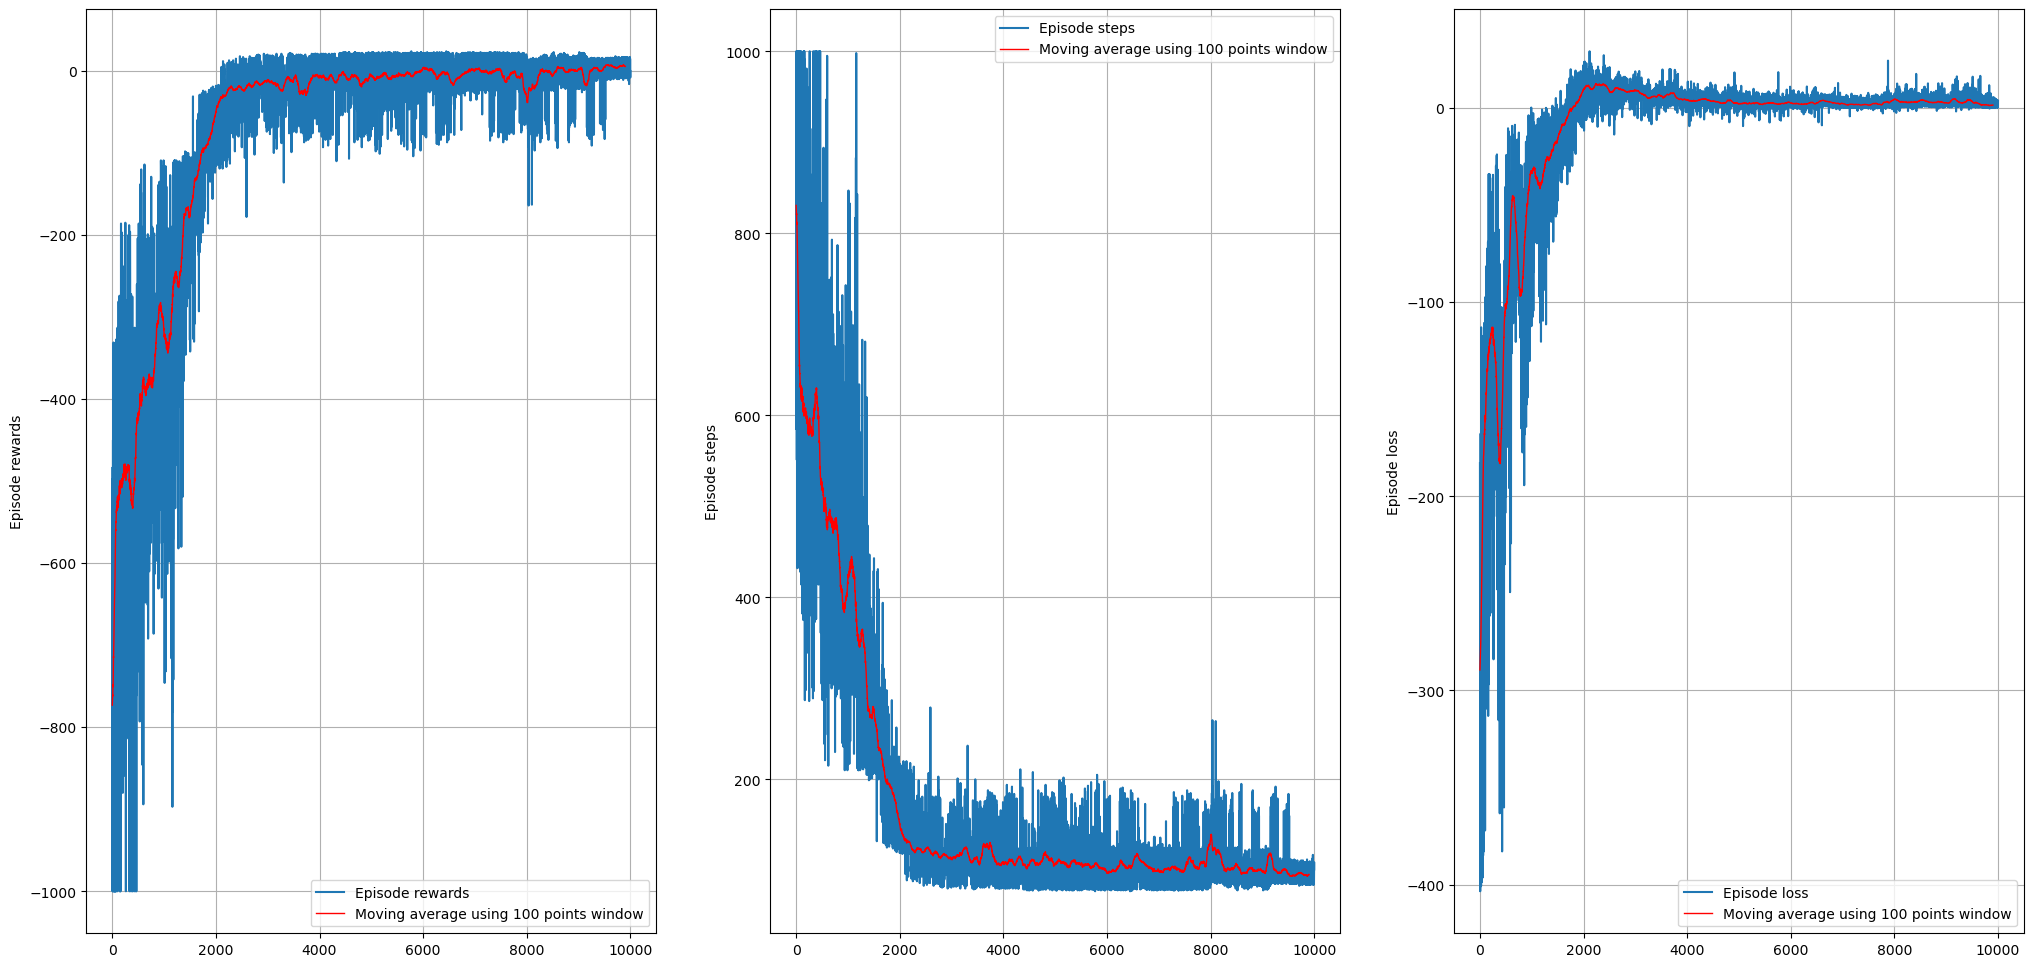

In [39]:
class MountainCar_ActionProbabilityModel(torch.nn.Module):
    def __init__(self, env):
        super().__init__()

        self.ENV_STATE_SIZE = env.tiles + env.tiles
        self.ENV_ACTIONS = 3

        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.ENV_STATE_SIZE, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 3),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, state):
        assert state.shape == (1, self.ENV_STATE_SIZE)

        a_probs = self.model(state)

        return a_probs


def reinforce_impl(env, learning_rate, discount_factor, max_episodes, max_episode_steps):
    model = MountainCar_ActionProbabilityModel(env)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_curves = defaultdict(list)

    for episode_i in tqdm(range(max_episodes)):
        episode_reward = 0
        episode_steps = 0
        episode_loss = 0

        state, info = env.reset()

        action_log_probs = []
        rewards = []

        model.train()

        for step_i in range(max_episode_steps):

            a_probs = model(
                state=torch.Tensor(state.reshape((1, -1))),
            )

            action = np.random.choice(a_probs.shape[1], p=a_probs.clone().detach().cpu().numpy()[0, :])
            action_prob = a_probs[0, action]

            state, reward, terminated, truncated, info = env.step(action)

            action_log_probs.append(torch.log(action_prob))
            rewards.append(reward)

            episode_reward += reward
            episode_steps += 1

            if terminated or truncated:
                break

        T = len(rewards)

        g_values = np.zeros(T)
        g_values[-1] = rewards[-1]
        for time in range(T - 2, -1, -1):
            g_values[time] = rewards[time] + g_values[time + 1] * discount_factor
        g_values = torch.from_numpy(g_values)

        loss = -torch.mean(torch.stack(action_log_probs) * g_values)
        episode_loss += loss.item()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        train_curves['Episode rewards'].append(episode_reward)
        train_curves['Episode steps'].append(episode_steps)
        train_curves['Episode loss'].append(episode_loss)

    return model, train_curves


def solve_reinforce():
    env = MountainCarEnv(
        max_steps=1000,
        tiles=32,
        action_velocity=0.001,   # Book value: 0.001
        positive_velocity_reward=0,   # Book value 0 (makes probability to get nonzero reward quite small - sparse rewards)
        successful_finish_reward=100)

    model, train_curves = reinforce_impl(
        env=env,
        learning_rate=1e-2,
        discount_factor=0.999,
        max_episodes=10000,
        max_episode_steps=1000)

    show_train_curves(train_curves)

    eval(
        env,
        model,
        max_episodes=100,
        max_episode_steps=1000)

    return env, model

env, model = solve_reinforce()

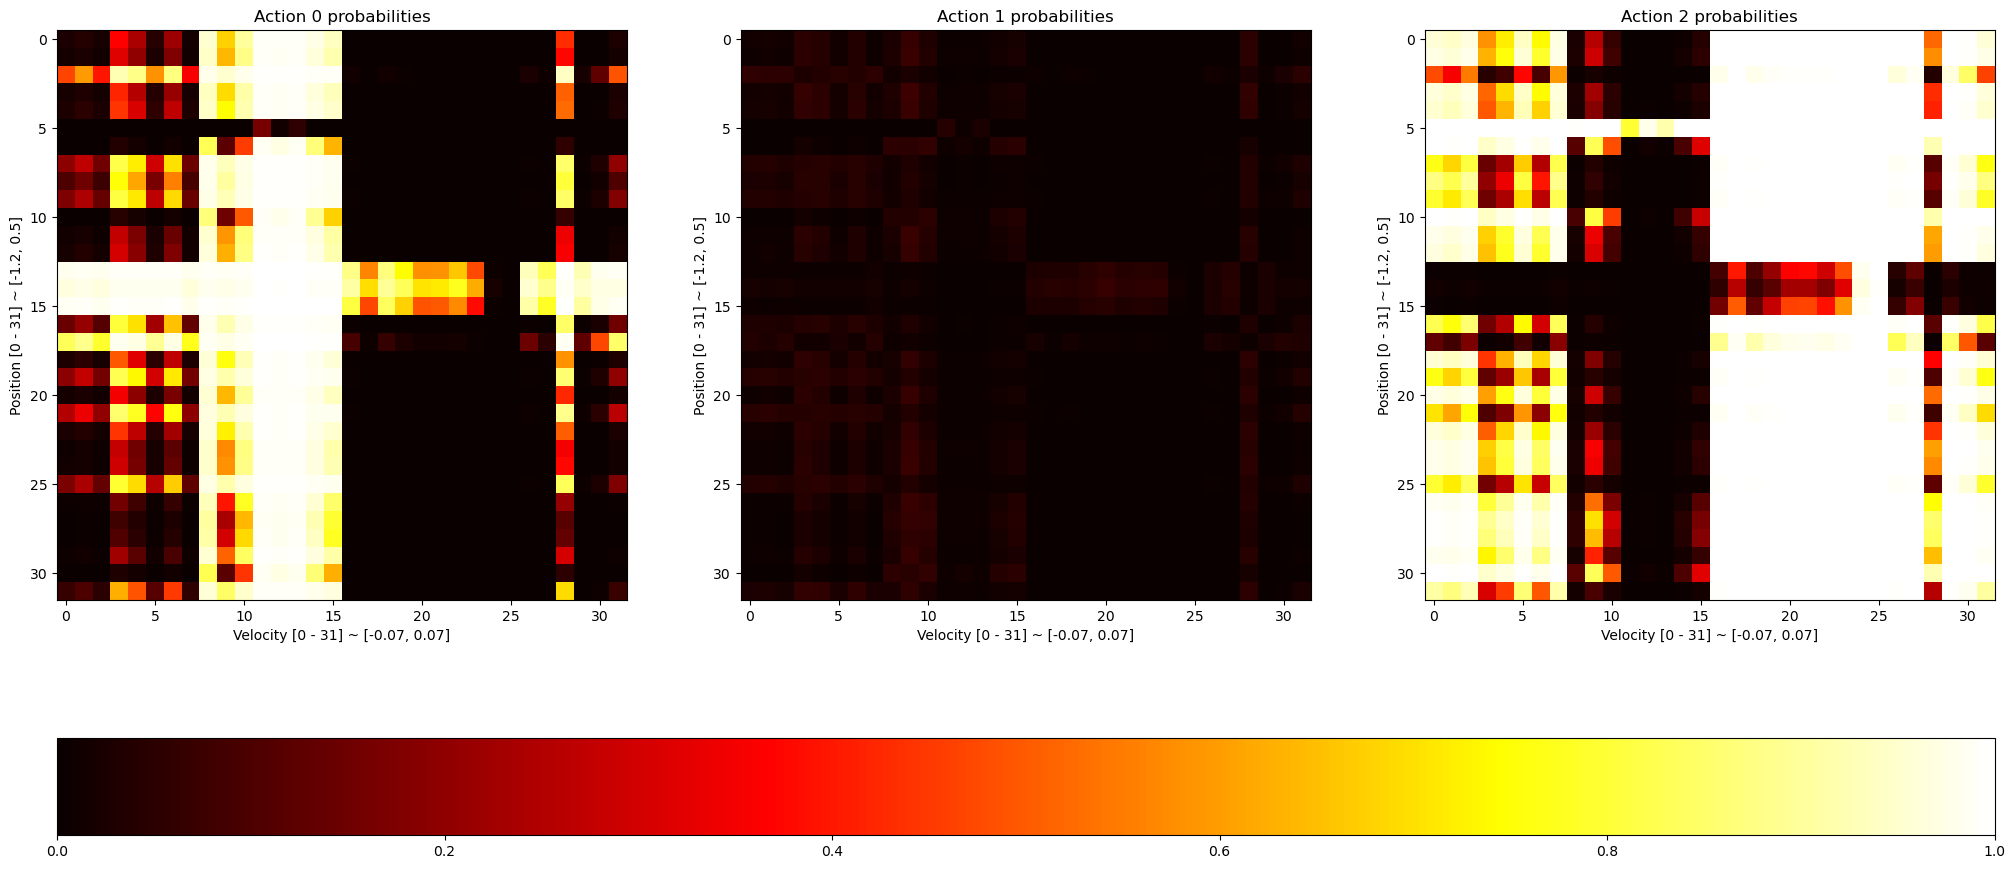

In [42]:
def show_action_probabilities(model):
    all_a_probs = np.zeros((3, env.tiles, env.tiles))
    for action, pos_i, vel_i in np.ndindex(all_a_probs.shape):

        state = np.zeros((env.tiles + env.tiles), dtype=np.int32)
        state[pos_i] = 1
        state[env.tiles + vel_i] = 1

        a_probs = call_model_once(model, state)


        all_a_probs[:, pos_i, vel_i] = a_probs

    vmin = np.min(all_a_probs)
    vmax = np.max(all_a_probs)

    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_size_inches(25, 12)

    for action in range(3):

        im = ax[action].imshow(all_a_probs[action, :, :], cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[action].set_title(f"Action {action} probabilities")
        ax[action].set_xlabel(f"Velocity [0 - {env.tiles - 1}] ~ {env.BOUNDARY_VEL}")
        ax[action].set_ylabel(f"Position [0 - {env.tiles - 1}] ~ {env.BOUNDARY_POS}")

    ax[-1].figure.colorbar(im, ax=ax, location='bottom')

show_action_probabilities(model)

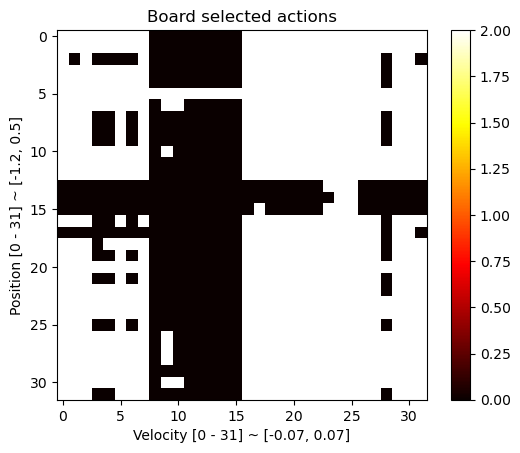

In [43]:
def show_actions(model):
    selected_actions = np.zeros((env.tiles, env.tiles))
    for pos_i, vel_i in np.ndindex(selected_actions.shape):
        state = np.zeros((env.tiles + env.tiles), dtype=np.int32)
        state[pos_i] = 1
        state[env.tiles + vel_i] = 1

        a_probs = call_model_once(model, state)

        selected_actions[pos_i, vel_i] = np.argmax(a_probs)

    im = plt.imshow(selected_actions, cmap='hot', interpolation='nearest', vmin=0, vmax=2)
    plt.title(f"Board selected actions")
    plt.colorbar(im)
    plt.xlabel(f"Velocity [0 - {env.tiles - 1}] ~ {env.BOUNDARY_VEL}")
    plt.ylabel(f"Position [0 - {env.tiles - 1}] ~ {env.BOUNDARY_POS}")

show_actions(model)